# Gradientenverfahren

In [1]:
from math import sqrt

class Vector:
    def __init__(self, *args, size=None):
        if size is None:
            self.array = args
        else:
            if type(size) == int:
                if args:
                    self.array = args * (size//len(args))
                else:
                    self.array = [0] * size
            else:
                raise Exception(f'Illegal size of type {type(size)}')
        self.dim = len(self.array)
    
    def __len__(self):
        return self.dim
    
    def __repr__(self):
        return f'Vector({", ".join(str(x) for x in self)})'
    
    def __str__(self):
        return str(self.array)
    
    def __or__(self, other):
        return Vector(*self.array, *other.array)
    
    def __lshift__(self, idx):
        return Vector(*self[idx:], *self[:idx])
    
    def __rshift__(self, idx):
        return Vector(*self[-idx:], *self[:-idx])

    def __getitem__(self, idx):
        if type(idx) == Vector:
            if self.dim != idx.dim:
                raise Exception(f'Vectors of dimensions {self.dim} and {idx.dim} are not compatible for addition')
            return Vector(*(x if y else 0 for x, y in zip(self, idx)))
        elif type(idx) == int:
            return self.array[idx % self.dim]
        elif type(idx) == slice:
            return self.array[idx]
        else:
            raise Exception(f'Illegal index of type {type(idx)}')
    
    def __iter__(self, idx=None):
        if idx is None:
            for x in self.array:
                yield x
        else:
            for x in self.array[idx]:
                yield x
                
    def __add__(self, other):
        if type(other) == Vector:
            if self.dim != other.dim:
                raise Exception(f'Vectors of dimensions {self.dim} and {other.dim} are not compatible for addition')
            return Vector(*(x + y for x, y in zip(self, other)))
        elif type(other) in {float, int, complex}:
            return Vector(x + other for x in self)
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        if type(other) == Vector:
            if self.dim != other.dim:
                raise Exception(f'Vectors of dimensions {self.dim} and {other.dim} are not compatible for addition')
            return Vector(*(x - y for x, y in zip(self, other)))
        elif type(other) in {float, int, complex}:
            return Vector(x - other for x in self)
    
    def __rsub__(self, other):
        return -1*self + other
    
    def __mul__(self, other):
        if type(other) == Vector:
            if self.dim != other.dim:
                raise Exception(f'Vectors of dimensions {self.dim} and {other.dim} are not compatible for dot product')
            return sum(x * y for x, y in zip(self, other))
        elif type(other) in {int, float, complex}:
            return Vector(*(x * other for x in self))
        else:
            raise Exception(f'Illegal index of type {type(other)}')
    
    def __rmul__(self, other):
        return self * other
    
    def __abs__(self):
        return sqrt(self*self)


In [2]:
from math import sin, cos


def grad(f, x, h=1e-8):
    hv = Vector(h, *(0 for _ in range(len(x) - 1)))
    return Vector(*((f(x + (hv>>i)) - f(x)) / h for i in range(len(x))))


def gradient_method(f, x, l=1, status=False):
    xs = [x|Vector(f(x))]
    for i in range(25):
        x_neu = x + l * grad(f, x)
        if status: print(f"""
Schritt {i}:
         x = {x}
         lambda = {l}
         f(x) = {f(x)}
         grad f(x) = {grad(f, x)}
         ||grad f(x)|| = {abs(grad(f, x))}

         x_neu = {x_neu}
         f(x_neu) = {f(x_neu)}""")
        if f(x_neu) > f(x):
            x_test = x + 2 * l * grad(f, x)
            if status: print(f"""

         Test mit doppelter Schrittweite (lambda = {2*l}):
         x_test = {x_test}
         f(x_test) = {f(x_test)}""")
            if f(x_test) > f(x_neu):
                x = x_test
                l *= 2
                if status: print("""
        Verdopple alte Schrittweite!""")
            else:
                x = x_neu
                if status: print("""
        Behalte alte Schrittweite!""")
        else:
            while f(x_neu) < f(x):
                l *= 0.5
                x_neu = x + l * grad(f, x)
            x = x_neu
            if status: print(f"""
            halbiere Schrittweite (lambda = {l}):
         x_neu = {x_neu}
         f(x_neu) = {f(x_neu)}""")
        xs.append(x|Vector(f(x)))
        if abs(grad(f, x)) <= 1e-5:
            if status: print(f"""
Ende wegen ||grad f(x)||<1e-5 bei 
         x = {x}
         lambda = {l}
         f(x) = {f(x)}
         grad f(x) = {grad(f, x)}
         ||grad f(x)|| = {abs(grad(f, x))}""")
            break
    if i == 24 and status:
        print(f"""
Ende wegen Schrittanzahl = 25 bei
         x = {x}
         lambda = {l}
         f(x) = {f(x)}
         grad f(x) = {grad(f, x)}
         ||grad f(x)|| = {abs(grad(f, x))}""")
    return x, xs
            

f = lambda x: sin(x[0] * x[1]) + sin(x[0]) + cos(x[1])
xf = Vector(0.2, -2.1)
_, xfs = gradient_method(f, xf, status=False)


g = lambda x: -(2*x[0]**2 - 2*x[0]*x[1] + x[1]**2 + x[2]**2 - 2*x[0] - 4*x[2])
xg = Vector(size=3)
_, xgs = gradient_method(g, xg, l=0.1, status=False)


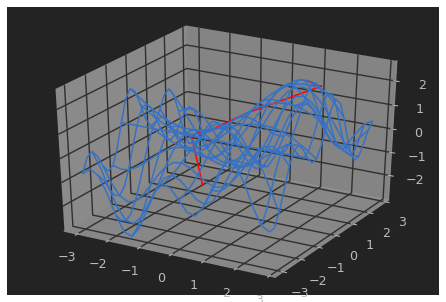

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
f = lambda x, y: np.sin(x * y) + np.sin(x) + np.cos(y)
Z = f(X, Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, cmap=cm.viridis)
ax.plot([x[0] for x in xfs], [x[1] for x in xfs], [x[2] for x in xfs], c='red')

plt.show()